# 1. Business Problem

## 1.1 Problem Statement
A cryptocurrency investment firm has hired us to predict the near future price of Bitcoin.
* They currently have data for select bitcoin exchanges, with minute to minute updates of OHLC (Open, High, Low, Close), Volume in BTC and indicated currency, and weighted bitcoin price.
* The data was collected for the time period of Jan 2012 to March 2018
* Our task is to build a price prediction model using this data.
* If we can build a model to predict future prices with an average error of under US Dollars 100, then our client will be very satisfied with the our resultant model.

## 1.2 Business Objectives and Constraints
* Deliverable: Trained model file
* Win condition: Avg. prediction error < \$100
* Model Interpretability will be useful
* No latency requirement

# 2. Machine Learning Problem
## 2.1 Data Overview

For this project:
* The dataset has 3273377 observations with minute by minute updates from Jan 2012 to March 2018.

#### Target Variable
* 'pred_weight' - Weight of BTC

#### Features of the data:

* Open - Opening price of BTC.
* High - Highest price of BTC during that time period.
* Close - Closing price of BTC.
* Low - Lowest price of BTC during that time period.
* Volume_(BTC): Amount of Bitcoin traded during that time period in BTC value.
* Volume_(USD): Amount of Bitcoin traded during that time period in US Dollars.
* Weighted_Price: Value of 1 Bitcoin in US Dollars.

## 2.2 Mapping business problem to ML problem
### 2.2.1 Type of Machine Learning Problem
It is a regression problem, where given the above set of features, we need to predict the weighted price of BTC after 10 mins.

### 2.2.2 Performance Metric (KPI)
**Since it is a regression problem, we will use the following regression metrics:**
#### 2.2.2.1 Root Mean Squared Error (RMSE)

![title](Images/rmse.gif)

#### 2.2.2.2 R-squared
![title](Images/r_squared.png)

Just remember the value of R suared must be at least greater than 0 and 1 in the best case

#### 2.2.2.3 Mean Absolute Error (MAE):
![title](Images/mae.png)

* Remember, our win-condition for this project is predicting within \$70,000 of true transaction prices, on average.
* Mean absolute error (or MAE) is the average absolute difference between predicted and actual values for our target variable. That exactly aligns with the terms of our win condition!
* So we're aiming to get MAE below 70,000

## 2.3 Train-Test Splits
**80-20**

# 3. Exploratory Data Analysis

#### Import the libraries

In [3]:
# NumPy for numerical computing
import numpy as np

# Pandas for DataFrames
import pandas as pd

# Matplotlib for visualization
from matplotlib import pyplot as plt
# display plots in the notebook
%matplotlib inline
# import color maps
from matplotlib.colors import ListedColormap

# Seaborn for easier visualization
import seaborn as sns

from math import sqrt

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

# Function for splitting training and test set
from sklearn.model_selection import train_test_split

# Libraries to perform hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Import classes for ML Models
from sklearn.linear_model import Ridge  ## Linear Regression + L2 regularization
from sklearn.svm import SVR ## Support Vector Regressor
from sklearn.ensemble import RandomForestRegressor #Random Forest
from sklearn.neighbors import KNeighborsRegressor #KNN Regressor
from sklearn import linear_model   #Lasso Regressor
from sklearn.tree import DecisionTreeRegressor #Decision Tree Regressor
from sklearn.model_selection import cross_val_score  #Cross - validation 


# Evaluation Metrics
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae

# To save the final model on disk
from sklearn.externals import joblib  ## Reference http://scikit-learn.org/stable/modules/model_persistence.html

## 3.1 Load real estate data from CSV

In [24]:
df = pd.read_csv('bitcoin_data.csv')

In [25]:
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
2,1325318040,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
3,1325318100,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
4,1325318160,4.39,4.39,4.39,4.39,0.455581,2.0,4.39


In [26]:
df.isnull().sum()

Timestamp            0
Open                 0
High                 0
Low                  0
Close                0
Volume_(BTC)         0
Volume_(Currency)    0
Weighted_Price       0
dtype: int64

In [27]:
df.shape

(3273377, 8)

## 3.2 Converting Timestamp to Date

In [28]:
df['Date'] = pd.to_datetime(df.Timestamp, unit = 's')

In [33]:
df = df.set_index('Date')

In [34]:
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Date,,,,,,,,
2011-12-31 07:52:00,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
2011-12-31 07:53:00,1325317980,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
2011-12-31 07:54:00,1325318040,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
2011-12-31 07:55:00,1325318100,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
2011-12-31 07:56:00,1325318160,4.39,4.39,4.39,4.39,0.455581,2.0,4.39


In [35]:
df.describe()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
count,3.273377e+06,3.273377e+06,3.273377e+06,3.273377e+06,3.273377e+06,3.273377e+06,3.273377e+06,3.273377e+06
mean,1.423719e+09,1.282265e+03,1.283527e+03,1.280822e+03,1.282248e+03,1.116149e+01,1.356582e+04,1.282163e+03
std,5.686463e+07,2.812084e+03,2.815636e+03,2.807936e+03,2.812042e+03,3.552989e+01,6.806235e+04,2.811795e+03
min,1.325318e+09,3.800000e+00,3.800000e+00,1.500000e+00,1.500000e+00,0.000000e+00,0.000000e+00,3.800000e+00
25%,1.374419e+09,1.178500e+02,1.179000e+02,1.177700e+02,1.178500e+02,4.703587e-01,7.120096e+01,1.178400e+02
50%,1.423908e+09,3.960100e+02,3.962900e+02,3.958200e+02,3.960000e+02,2.160980e+00,4.150598e+02,3.960014e+02
75%,1.473008e+09,7.211600e+02,7.219800e+02,7.205000e+02,7.210500e+02,9.000000e+00,3.371765e+03,7.211458e+02
max,1.522109e+09,1.966576e+04,1.966600e+04,1.964996e+04,1.966575e+04,5.853852e+03,5.483271e+06,1.966330e+04


## 3.3 Resampling the data.
* Since the dataset contains value of Bitcoin at one minute intervals it wouldn't be efficient to predict the weighted price for the next minute.
* Hence we will resample the data into 10 mins interval.

In [37]:
#Resampling the data in 10 min intervals
df = df.resample('10T').agg({'Open': 'mean', 'High': 'mean', 
    'Low': 'mean', 'Close': 'mean', 'Volume_(BTC)': 'sum',
    'Volume_(Currency)': 'sum', 'Weighted_Price': 'mean', 'Timestamp': 'min'})  

In [38]:
df.shape

(327986, 8)

## 3.4 Creating Target Variable
### We will now create a new column 'pred_weight' which will be our target variable.
* This can be obtained by rolling the already available feature 'Weighted_Price'  one place above so that it will be like predicting the price of next 10th minute timeframe

In [39]:
df['pred_weight'] = np.roll(df['Weighted_Price'], -1)

In [41]:
df.tail()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Timestamp,pred_weight
Date,,,,,,,,,
2018-03-26 23:20:00,8216.419,8228.551,8207.362,8215.391,153.945083,1.267740e+06,8218.781100,1.522106e+09,8187.745762
2018-03-26 23:30:00,8189.055,8198.373,8179.008,8186.055,122.962332,1.004773e+06,8187.745762,1.522107e+09,8167.662603
2018-03-26 23:40:00,8168.010,8173.385,8163.228,8167.658,41.068976,3.355007e+05,8167.662603,1.522108e+09,8159.550796
2018-03-26 23:50:00,8160.630,8165.254,8153.448,8158.256,61.203973,4.984852e+05,8159.550796,1.522108e+09,8155.146220
2018-03-27 00:00:00,8152.260,8164.680,8151.370,8153.040,17.758130,1.448201e+05,8155.146220,1.522109e+09,4.390000


In [42]:
df = df.iloc[:-1]
df.tail()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Timestamp,pred_weight
Date,,,,,,,,,
2018-03-26 23:10:00,8190.726,8197.484,8187.408,8192.613,21.636469,1.772500e+05,8192.824829,1.522106e+09,8218.781100
2018-03-26 23:20:00,8216.419,8228.551,8207.362,8215.391,153.945083,1.267740e+06,8218.781100,1.522106e+09,8187.745762
2018-03-26 23:30:00,8189.055,8198.373,8179.008,8186.055,122.962332,1.004773e+06,8187.745762,1.522107e+09,8167.662603
2018-03-26 23:40:00,8168.010,8173.385,8163.228,8167.658,41.068976,3.355007e+05,8167.662603,1.522108e+09,8159.550796
2018-03-26 23:50:00,8160.630,8165.254,8153.448,8158.256,61.203973,4.984852e+05,8159.550796,1.522108e+09,8155.146220


In [46]:
df.isnull().sum()

Open                 646
High                 646
Low                  646
Close                646
Volume_(BTC)           0
Volume_(Currency)      0
Weighted_Price       646
Timestamp            646
pred_weight          646
dtype: int64

## 3.5 Some null values are generated after resampling. Removing these null values.

In [55]:
df = df.dropna(axis = 0)  #Removing the rows with NaN values

In [56]:
df.shape

(327338, 9)

In [59]:
df['Date'] = pd.to_datetime(df.Timestamp, unit = 's')

In [60]:
# Save cleaned dataframe to new file
df.to_csv('cleaned_df.csv', index=None)

In [2]:
# Load cleaned dataframe
df = pd.read_csv('cleaned_df.csv')
df.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Timestamp,pred_weight,Date
0,4.39,4.39,4.39,4.39,3.644647,16.0,4.39,1.325318e+09,4.39,2011-12-31 07:52:00
1,4.39,4.39,4.39,4.39,4.555809,20.0,4.39,1.325318e+09,4.39,2011-12-31 08:00:00
2,4.39,4.39,4.39,4.39,4.555809,20.0,4.39,1.325319e+09,4.39,2011-12-31 08:10:00
3,4.39,4.39,4.39,4.39,4.555809,20.0,4.39,1.325320e+09,4.39,2011-12-31 08:20:00
4,4.39,4.39,4.39,4.39,4.555809,20.0,4.39,1.325320e+09,4.39,2011-12-31 08:30:00


## 3.6 Correlation Heatmap

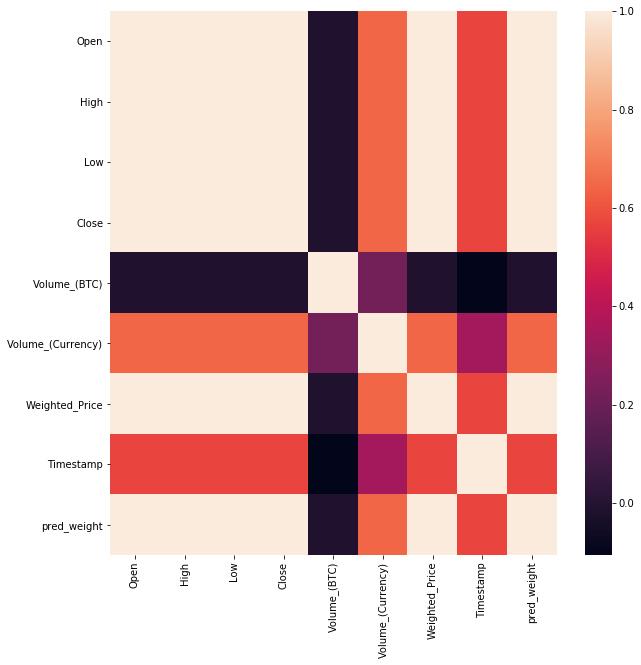

In [51]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr())

## 3.7 Time Series Graph

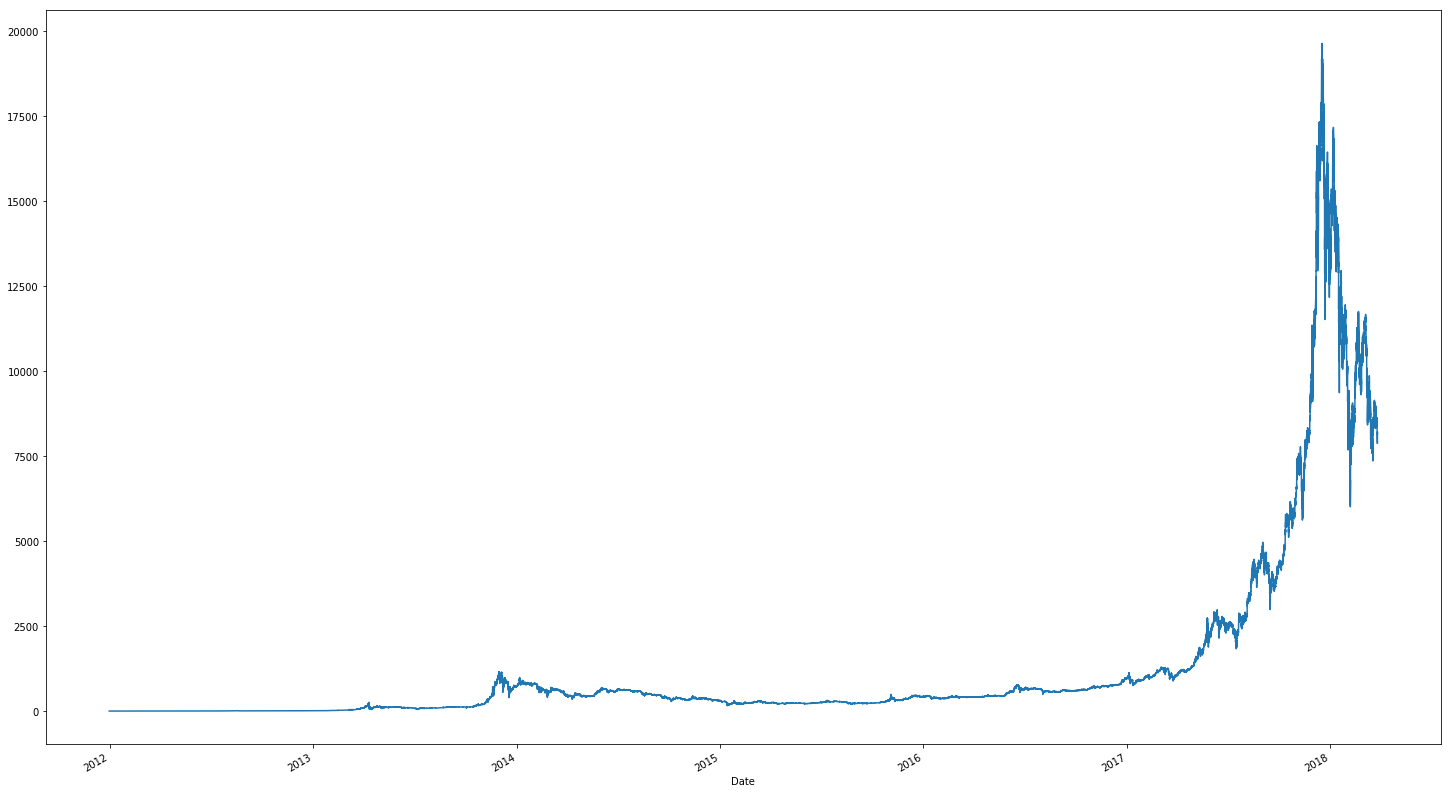

In [53]:
df['Weighted_Price'].plot(figsize = (25,15))

# Observations:
* From the end of 2017, there has been a rapid rise in value of Bitcoin.
* December 2017 showed the highest value of bitcoin.
* The period between 2012 to mid 2016 shows no significant fluctuations has been observed.

In [47]:
df['Close'].describe()

count    3.273377e+06
mean     1.282248e+03
std      2.812042e+03
min      1.500000e+00
25%      1.178500e+02
50%      3.960000e+02
75%      7.210500e+02
max      1.966575e+04
Name: Close, dtype: float64

# 4 Feature Engineering

## 4.1 Indicator Variable:

## 2013 Price Hike

![title](Images/2013_spike.png)

* Source: CNBC

## Price Hike from May to September 2017 (Crossed $ 5000 mark)

![title](Images/may_spike.png)

## Price Hike from mid - October to December 2017 (all-time high of $19,783.21 on Dec. 17.)

![title](Images/2017_spike.png)

* Source: Coindesk

In [3]:
df['Price_Hike'] = 0

In [26]:
def price_hike(df,date_from,date_to):
    #Take the time period from user and find out its corresponding timestamp.
    #Set the value of Price_Hike = 1 between the given time period.
    #Apply for loop throughout the dataframe and set value = 1 when the required timestamp is detected
    
    idx_start =  df.index[df['Date'] == date_from]
    idx_end =  df.index[df['Date'] == date_to]
    print("Index starts from " + str(idx_start[0]) + " to " + str(idx_end[0]))
    for i in range(idx_start[0], idx_end[0] + 1):
            print(i)
            df['Price_Hike'][i] = 1
    return df 

In [22]:
df_sample = price_hike(df, '2013-02-14 00:00:00', '2013-09-27 00:00:00')

59137
59138
59139
59140
59141
59142
59143
59144
59145
59146
59147
59148
59149
59150
59151
59152
59153
59154
59155
59156
59157
59158
59159
59160
59161
59162
59163
59164
59165
59166
59167
59168
59169
59170
59171
59172
59173
59174
59175
59176
59177
59178
59179
59180
59181
59182
59183
59184
59185
59186
59187
59188
59189
59190
59191
59192
59193
59194
59195
59196
59197
59198
59199
59200
59201
59202
59203
59204
59205
59206
59207
59208
59209
59210
59211
59212
59213
59214
59215
59216
59217
59218
59219
59220
59221
59222
59223
59224
59225
59226
59227
59228
59229
59230
59231
59232
59233
59234
59235
59236
59237
59238
59239
59240
59241
59242
59243
59244
59245
59246
59247
59248
59249
59250
59251
59252
59253
59254
59255
59256
59257
59258
59259
59260
59261
59262
59263
59264
59265
59266
59267
59268
59269
59270
59271
59272
59273
59274
59275
59276
59277
59278
59279
59280
59281
59282
59283
59284
59285
59286
59287
59288
59289
59290
59291
59292
59293
59294
59295
59296
59297
59298
59299
59300
59301
59302
5930

60505
60506
60507
60508
60509
60510
60511
60512
60513
60514
60515
60516
60517
60518
60519
60520
60521
60522
60523
60524
60525
60526
60527
60528
60529
60530
60531
60532
60533
60534
60535
60536
60537
60538
60539
60540
60541
60542
60543
60544
60545
60546
60547
60548
60549
60550
60551
60552
60553
60554
60555
60556
60557
60558
60559
60560
60561
60562
60563
60564
60565
60566
60567
60568
60569
60570
60571
60572
60573
60574
60575
60576
60577
60578
60579
60580
60581
60582
60583
60584
60585
60586
60587
60588
60589
60590
60591
60592
60593
60594
60595
60596
60597
60598
60599
60600
60601
60602
60603
60604
60605
60606
60607
60608
60609
60610
60611
60612
60613
60614
60615
60616
60617
60618
60619
60620
60621
60622
60623
60624
60625
60626
60627
60628
60629
60630
60631
60632
60633
60634
60635
60636
60637
60638
60639
60640
60641
60642
60643
60644
60645
60646
60647
60648
60649
60650
60651
60652
60653
60654
60655
60656
60657
60658
60659
60660
60661
60662
60663
60664
60665
60666
60667
60668
60669
60670
6067

61874
61875
61876
61877
61878
61879
61880
61881
61882
61883
61884
61885
61886
61887
61888
61889
61890
61891
61892
61893
61894
61895
61896
61897
61898
61899
61900
61901
61902
61903
61904
61905
61906
61907
61908
61909
61910
61911
61912
61913
61914
61915
61916
61917
61918
61919
61920
61921
61922
61923
61924
61925
61926
61927
61928
61929
61930
61931
61932
61933
61934
61935
61936
61937
61938
61939
61940
61941
61942
61943
61944
61945
61946
61947
61948
61949
61950
61951
61952
61953
61954
61955
61956
61957
61958
61959
61960
61961
61962
61963
61964
61965
61966
61967
61968
61969
61970
61971
61972
61973
61974
61975
61976
61977
61978
61979
61980
61981
61982
61983
61984
61985
61986
61987
61988
61989
61990
61991
61992
61993
61994
61995
61996
61997
61998
61999
62000
62001
62002
62003
62004
62005
62006
62007
62008
62009
62010
62011
62012
62013
62014
62015
62016
62017
62018
62019
62020
62021
62022
62023
62024
62025
62026
62027
62028
62029
62030
62031
62032
62033
62034
62035
62036
62037
62038
62039
6204

63240
63241
63242
63243
63244
63245
63246
63247
63248
63249
63250
63251
63252
63253
63254
63255
63256
63257
63258
63259
63260
63261
63262
63263
63264
63265
63266
63267
63268
63269
63270
63271
63272
63273
63274
63275
63276
63277
63278
63279
63280
63281
63282
63283
63284
63285
63286
63287
63288
63289
63290
63291
63292
63293
63294
63295
63296
63297
63298
63299
63300
63301
63302
63303
63304
63305
63306
63307
63308
63309
63310
63311
63312
63313
63314
63315
63316
63317
63318
63319
63320
63321
63322
63323
63324
63325
63326
63327
63328
63329
63330
63331
63332
63333
63334
63335
63336
63337
63338
63339
63340
63341
63342
63343
63344
63345
63346
63347
63348
63349
63350
63351
63352
63353
63354
63355
63356
63357
63358
63359
63360
63361
63362
63363
63364
63365
63366
63367
63368
63369
63370
63371
63372
63373
63374
63375
63376
63377
63378
63379
63380
63381
63382
63383
63384
63385
63386
63387
63388
63389
63390
63391
63392
63393
63394
63395
63396
63397
63398
63399
63400
63401
63402
63403
63404
63405
6340

64607
64608
64609
64610
64611
64612
64613
64614
64615
64616
64617
64618
64619
64620
64621
64622
64623
64624
64625
64626
64627
64628
64629
64630
64631
64632
64633
64634
64635
64636
64637
64638
64639
64640
64641
64642
64643
64644
64645
64646
64647
64648
64649
64650
64651
64652
64653
64654
64655
64656
64657
64658
64659
64660
64661
64662
64663
64664
64665
64666
64667
64668
64669
64670
64671
64672
64673
64674
64675
64676
64677
64678
64679
64680
64681
64682
64683
64684
64685
64686
64687
64688
64689
64690
64691
64692
64693
64694
64695
64696
64697
64698
64699
64700
64701
64702
64703
64704
64705
64706
64707
64708
64709
64710
64711
64712
64713
64714
64715
64716
64717
64718
64719
64720
64721
64722
64723
64724
64725
64726
64727
64728
64729
64730
64731
64732
64733
64734
64735
64736
64737
64738
64739
64740
64741
64742
64743
64744
64745
64746
64747
64748
64749
64750
64751
64752
64753
64754
64755
64756
64757
64758
64759
64760
64761
64762
64763
64764
64765
64766
64767
64768
64769
64770
64771
64772
6477

65973
65974
65975
65976
65977
65978
65979
65980
65981
65982
65983
65984
65985
65986
65987
65988
65989
65990
65991
65992
65993
65994
65995
65996
65997
65998
65999
66000
66001
66002
66003
66004
66005
66006
66007
66008
66009
66010
66011
66012
66013
66014
66015
66016
66017
66018
66019
66020
66021
66022
66023
66024
66025
66026
66027
66028
66029
66030
66031
66032
66033
66034
66035
66036
66037
66038
66039
66040
66041
66042
66043
66044
66045
66046
66047
66048
66049
66050
66051
66052
66053
66054
66055
66056
66057
66058
66059
66060
66061
66062
66063
66064
66065
66066
66067
66068
66069
66070
66071
66072
66073
66074
66075
66076
66077
66078
66079
66080
66081
66082
66083
66084
66085
66086
66087
66088
66089
66090
66091
66092
66093
66094
66095
66096
66097
66098
66099
66100
66101
66102
66103
66104
66105
66106
66107
66108
66109
66110
66111
66112
66113
66114
66115
66116
66117
66118
66119
66120
66121
66122
66123
66124
66125
66126
66127
66128
66129
66130
66131
66132
66133
66134
66135
66136
66137
66138
6613

67340
67341
67342
67343
67344
67345
67346
67347
67348
67349
67350
67351
67352
67353
67354
67355
67356
67357
67358
67359
67360
67361
67362
67363
67364
67365
67366
67367
67368
67369
67370
67371
67372
67373
67374
67375
67376
67377
67378
67379
67380
67381
67382
67383
67384
67385
67386
67387
67388
67389
67390
67391
67392
67393
67394
67395
67396
67397
67398
67399
67400
67401
67402
67403
67404
67405
67406
67407
67408
67409
67410
67411
67412
67413
67414
67415
67416
67417
67418
67419
67420
67421
67422
67423
67424
67425
67426
67427
67428
67429
67430
67431
67432
67433
67434
67435
67436
67437
67438
67439
67440
67441
67442
67443
67444
67445
67446
67447
67448
67449
67450
67451
67452
67453
67454
67455
67456
67457
67458
67459
67460
67461
67462
67463
67464
67465
67466
67467
67468
67469
67470
67471
67472
67473
67474
67475
67476
67477
67478
67479
67480
67481
67482
67483
67484
67485
67486
67487
67488
67489
67490
67491
67492
67493
67494
67495
67496
67497
67498
67499
67500
67501
67502
67503
67504
67505
6750

68712
68713
68714
68715
68716
68717
68718
68719
68720
68721
68722
68723
68724
68725
68726
68727
68728
68729
68730
68731
68732
68733
68734
68735
68736
68737
68738
68739
68740
68741
68742
68743
68744
68745
68746
68747
68748
68749
68750
68751
68752
68753
68754
68755
68756
68757
68758
68759
68760
68761
68762
68763
68764
68765
68766
68767
68768
68769
68770
68771
68772
68773
68774
68775
68776
68777
68778
68779
68780
68781
68782
68783
68784
68785
68786
68787
68788
68789
68790
68791
68792
68793
68794
68795
68796
68797
68798
68799
68800
68801
68802
68803
68804
68805
68806
68807
68808
68809
68810
68811
68812
68813
68814
68815
68816
68817
68818
68819
68820
68821
68822
68823
68824
68825
68826
68827
68828
68829
68830
68831
68832
68833
68834
68835
68836
68837
68838
68839
68840
68841
68842
68843
68844
68845
68846
68847
68848
68849
68850
68851
68852
68853
68854
68855
68856
68857
68858
68859
68860
68861
68862
68863
68864
68865
68866
68867
68868
68869
68870
68871
68872
68873
68874
68875
68876
68877
6887

70079
70080
70081
70082
70083
70084
70085
70086
70087
70088
70089
70090
70091
70092
70093
70094
70095
70096
70097
70098
70099
70100
70101
70102
70103
70104
70105
70106
70107
70108
70109
70110
70111
70112
70113
70114
70115
70116
70117
70118
70119
70120
70121
70122
70123
70124
70125
70126
70127
70128
70129
70130
70131
70132
70133
70134
70135
70136
70137
70138
70139
70140
70141
70142
70143
70144
70145
70146
70147
70148
70149
70150
70151
70152
70153
70154
70155
70156
70157
70158
70159
70160
70161
70162
70163
70164
70165
70166
70167
70168
70169
70170
70171
70172
70173
70174
70175
70176
70177
70178
70179
70180
70181
70182
70183
70184
70185
70186
70187
70188
70189
70190
70191
70192
70193
70194
70195
70196
70197
70198
70199
70200
70201
70202
70203
70204
70205
70206
70207
70208
70209
70210
70211
70212
70213
70214
70215
70216
70217
70218
70219
70220
70221
70222
70223
70224
70225
70226
70227
70228
70229
70230
70231
70232
70233
70234
70235
70236
70237
70238
70239
70240
70241
70242
70243
70244
7024

71445
71446
71447
71448
71449
71450
71451
71452
71453
71454
71455
71456
71457
71458
71459
71460
71461
71462
71463
71464
71465
71466
71467
71468
71469
71470
71471
71472
71473
71474
71475
71476
71477
71478
71479
71480
71481
71482
71483
71484
71485
71486
71487
71488
71489
71490
71491
71492
71493
71494
71495
71496
71497
71498
71499
71500
71501
71502
71503
71504
71505
71506
71507
71508
71509
71510
71511
71512
71513
71514
71515
71516
71517
71518
71519
71520
71521
71522
71523
71524
71525
71526
71527
71528
71529
71530
71531
71532
71533
71534
71535
71536
71537
71538
71539
71540
71541
71542
71543
71544
71545
71546
71547
71548
71549
71550
71551
71552
71553
71554
71555
71556
71557
71558
71559
71560
71561
71562
71563
71564
71565
71566
71567
71568
71569
71570
71571
71572
71573
71574
71575
71576
71577
71578
71579
71580
71581
71582
71583
71584
71585
71586
71587
71588
71589
71590
71591
71592
71593
71594
71595
71596
71597
71598
71599
71600
71601
71602
71603
71604
71605
71606
71607
71608
71609
71610
7161

72816
72817
72818
72819
72820
72821
72822
72823
72824
72825
72826
72827
72828
72829
72830
72831
72832
72833
72834
72835
72836
72837
72838
72839
72840
72841
72842
72843
72844
72845
72846
72847
72848
72849
72850
72851
72852
72853
72854
72855
72856
72857
72858
72859
72860
72861
72862
72863
72864
72865
72866
72867
72868
72869
72870
72871
72872
72873
72874
72875
72876
72877
72878
72879
72880
72881
72882
72883
72884
72885
72886
72887
72888
72889
72890
72891
72892
72893
72894
72895
72896
72897
72898
72899
72900
72901
72902
72903
72904
72905
72906
72907
72908
72909
72910
72911
72912
72913
72914
72915
72916
72917
72918
72919
72920
72921
72922
72923
72924
72925
72926
72927
72928
72929
72930
72931
72932
72933
72934
72935
72936
72937
72938
72939
72940
72941
72942
72943
72944
72945
72946
72947
72948
72949
72950
72951
72952
72953
72954
72955
72956
72957
72958
72959
72960
72961
72962
72963
72964
72965
72966
72967
72968
72969
72970
72971
72972
72973
72974
72975
72976
72977
72978
72979
72980
72981
7298

74182
74183
74184
74185
74186
74187
74188
74189
74190
74191
74192
74193
74194
74195
74196
74197
74198
74199
74200
74201
74202
74203
74204
74205
74206
74207
74208
74209
74210
74211
74212
74213
74214
74215
74216
74217
74218
74219
74220
74221
74222
74223
74224
74225
74226
74227
74228
74229
74230
74231
74232
74233
74234
74235
74236
74237
74238
74239
74240
74241
74242
74243
74244
74245
74246
74247
74248
74249
74250
74251
74252
74253
74254
74255
74256
74257
74258
74259
74260
74261
74262
74263
74264
74265
74266
74267
74268
74269
74270
74271
74272
74273
74274
74275
74276
74277
74278
74279
74280
74281
74282
74283
74284
74285
74286
74287
74288
74289
74290
74291
74292
74293
74294
74295
74296
74297
74298
74299
74300
74301
74302
74303
74304
74305
74306
74307
74308
74309
74310
74311
74312
74313
74314
74315
74316
74317
74318
74319
74320
74321
74322
74323
74324
74325
74326
74327
74328
74329
74330
74331
74332
74333
74334
74335
74336
74337
74338
74339
74340
74341
74342
74343
74344
74345
74346
74347
7434

76914
76915
76916
76917
76918
76919
76920
76921
76922
76923
76924
76925
76926
76927
76928
76929
76930
76931
76932
76933
76934
76935
76936
76937
76938
76939
76940
76941
76942
76943
76944
76945
76946
76947
76948
76949
76950
76951
76952
76953
76954
76955
76956
76957
76958
76959
76960
76961
76962
76963
76964
76965
76966
76967
76968
76969
76970
76971
76972
76973
76974
76975
76976
76977
76978
76979
76980
76981
76982
76983
76984
76985
76986
76987
76988
76989
76990
76991
76992
76993
76994
76995
76996
76997
76998
76999
77000
77001
77002
77003
77004
77005
77006
77007
77008
77009
77010
77011
77012
77013
77014
77015
77016
77017
77018
77019
77020
77021
77022
77023
77024
77025
77026
77027
77028
77029
77030
77031
77032
77033
77034
77035
77036
77037
77038
77039
77040
77041
77042
77043
77044
77045
77046
77047
77048
77049
77050
77051
77052
77053
77054
77055
77056
77057
77058
77059
77060
77061
77062
77063
77064
77065
77066
77067
77068
77069
77070
77071
77072
77073
77074
77075
77076
77077
77078
77079
7708

78283
78284
78285
78286
78287
78288
78289
78290
78291
78292
78293
78294
78295
78296
78297
78298
78299
78300
78301
78302
78303
78304
78305
78306
78307
78308
78309
78310
78311
78312
78313
78314
78315
78316
78317
78318
78319
78320
78321
78322
78323
78324
78325
78326
78327
78328
78329
78330
78331
78332
78333
78334
78335
78336
78337
78338
78339
78340
78341
78342
78343
78344
78345
78346
78347
78348
78349
78350
78351
78352
78353
78354
78355
78356
78357
78358
78359
78360
78361
78362
78363
78364
78365
78366
78367
78368
78369
78370
78371
78372
78373
78374
78375
78376
78377
78378
78379
78380
78381
78382
78383
78384
78385
78386
78387
78388
78389
78390
78391
78392
78393
78394
78395
78396
78397
78398
78399
78400
78401
78402
78403
78404
78405
78406
78407
78408
78409
78410
78411
78412
78413
78414
78415
78416
78417
78418
78419
78420
78421
78422
78423
78424
78425
78426
78427
78428
78429
78430
78431
78432
78433
78434
78435
78436
78437
78438
78439
78440
78441
78442
78443
78444
78445
78446
78447
78448
7844

79653
79654
79655
79656
79657
79658
79659
79660
79661
79662
79663
79664
79665
79666
79667
79668
79669
79670
79671
79672
79673
79674
79675
79676
79677
79678
79679
79680
79681
79682
79683
79684
79685
79686
79687
79688
79689
79690
79691
79692
79693
79694
79695
79696
79697
79698
79699
79700
79701
79702
79703
79704
79705
79706
79707
79708
79709
79710
79711
79712
79713
79714
79715
79716
79717
79718
79719
79720
79721
79722
79723
79724
79725
79726
79727
79728
79729
79730
79731
79732
79733
79734
79735
79736
79737
79738
79739
79740
79741
79742
79743
79744
79745
79746
79747
79748
79749
79750
79751
79752
79753
79754
79755
79756
79757
79758
79759
79760
79761
79762
79763
79764
79765
79766
79767
79768
79769
79770
79771
79772
79773
79774
79775
79776
79777
79778
79779
79780
79781
79782
79783
79784
79785
79786
79787
79788
79789
79790
79791
79792
79793
79794
79795
79796
79797
79798
79799
79800
79801
79802
79803
79804
79805
79806
79807
79808
79809
79810
79811
79812
79813
79814
79815
79816
79817
79818
7981

81022
81023
81024
81025
81026
81027
81028
81029
81030
81031
81032
81033
81034
81035
81036
81037
81038
81039
81040
81041
81042
81043
81044
81045
81046
81047
81048
81049
81050
81051
81052
81053
81054
81055
81056
81057
81058
81059
81060
81061
81062
81063
81064
81065
81066
81067
81068
81069
81070
81071
81072
81073
81074
81075
81076
81077
81078
81079
81080
81081
81082
81083
81084
81085
81086
81087
81088
81089
81090
81091
81092
81093
81094
81095
81096
81097
81098
81099
81100
81101
81102
81103
81104
81105
81106
81107
81108
81109
81110
81111
81112
81113
81114
81115
81116
81117
81118
81119
81120
81121
81122
81123
81124
81125
81126
81127
81128
81129
81130
81131
81132
81133
81134
81135
81136
81137
81138
81139
81140
81141
81142
81143
81144
81145
81146
81147
81148
81149
81150
81151
81152
81153
81154
81155
81156
81157
81158
81159
81160
81161
81162
81163
81164
81165
81166
81167
81168
81169
81170
81171
81172
81173
81174
81175
81176
81177
81178
81179
81180
81181
81182
81183
81184
81185
81186
81187
8118

83752
83753
83754
83755
83756
83757
83758
83759
83760
83761
83762
83763
83764
83765
83766
83767
83768
83769
83770
83771
83772
83773
83774
83775
83776
83777
83778
83779
83780
83781
83782
83783
83784
83785
83786
83787
83788
83789
83790
83791
83792
83793
83794
83795
83796
83797
83798
83799
83800
83801
83802
83803
83804
83805
83806
83807
83808
83809
83810
83811
83812
83813
83814
83815
83816
83817
83818
83819
83820
83821
83822
83823
83824
83825
83826
83827
83828
83829
83830
83831
83832
83833
83834
83835
83836
83837
83838
83839
83840
83841
83842
83843
83844
83845
83846
83847
83848
83849
83850
83851
83852
83853
83854
83855
83856
83857
83858
83859
83860
83861
83862
83863
83864
83865
83866
83867
83868
83869
83870
83871
83872
83873
83874
83875
83876
83877
83878
83879
83880
83881
83882
83883
83884
83885
83886
83887
83888
83889
83890
83891
83892
83893
83894
83895
83896
83897
83898
83899
83900
83901
83902
83903
83904
83905
83906
83907
83908
83909
83910
83911
83912
83913
83914
83915
83916
83917
8391

85121
85122
85123
85124
85125
85126
85127
85128
85129
85130
85131
85132
85133
85134
85135
85136
85137
85138
85139
85140
85141
85142
85143
85144
85145
85146
85147
85148
85149
85150
85151
85152
85153
85154
85155
85156
85157
85158
85159
85160
85161
85162
85163
85164
85165
85166
85167
85168
85169
85170
85171
85172
85173
85174
85175
85176
85177
85178
85179
85180
85181
85182
85183
85184
85185
85186
85187
85188
85189
85190
85191
85192
85193
85194
85195
85196
85197
85198
85199
85200
85201
85202
85203
85204
85205
85206
85207
85208
85209
85210
85211
85212
85213
85214
85215
85216
85217
85218
85219
85220
85221
85222
85223
85224
85225
85226
85227
85228
85229
85230
85231
85232
85233
85234
85235
85236
85237
85238
85239
85240
85241
85242
85243
85244
85245
85246
85247
85248
85249
85250
85251
85252
85253
85254
85255
85256
85257
85258
85259
85260
85261
85262
85263
85264
85265
85266
85267
85268
85269
85270
85271
85272
85273
85274
85275
85276
85277
85278
85279
85280
85281
85282
85283
85284
85285
85286
8528

86492
86493
86494
86495
86496
86497
86498
86499
86500
86501
86502
86503
86504
86505
86506
86507
86508
86509
86510
86511
86512
86513
86514
86515
86516
86517
86518
86519
86520
86521
86522
86523
86524
86525
86526
86527
86528
86529
86530
86531
86532
86533
86534
86535
86536
86537
86538
86539
86540
86541
86542
86543
86544
86545
86546
86547
86548
86549
86550
86551
86552
86553
86554
86555
86556
86557
86558
86559
86560
86561
86562
86563
86564
86565
86566
86567
86568
86569
86570
86571
86572
86573
86574
86575
86576
86577
86578
86579
86580
86581
86582
86583
86584
86585
86586
86587
86588
86589
86590
86591
86592
86593
86594
86595
86596
86597
86598
86599
86600
86601
86602
86603
86604
86605
86606
86607
86608
86609
86610
86611
86612
86613
86614
86615
86616
86617
86618
86619
86620
86621
86622
86623
86624
86625
86626
86627
86628
86629
86630
86631
86632
86633
86634
86635
86636
86637
86638
86639
86640
86641
86642
86643
86644
86645
86646
86647
86648
86649
86650
86651
86652
86653
86654
86655
86656
86657
8665

87863
87864
87865
87866
87867
87868
87869
87870
87871
87872
87873
87874
87875
87876
87877
87878
87879
87880
87881
87882
87883
87884
87885
87886
87887
87888
87889
87890
87891
87892
87893
87894
87895
87896
87897
87898
87899
87900
87901
87902
87903
87904
87905
87906
87907
87908
87909
87910
87911
87912
87913
87914
87915
87916
87917
87918
87919
87920
87921
87922
87923
87924
87925
87926
87927
87928
87929
87930
87931
87932
87933
87934
87935
87936
87937
87938
87939
87940
87941
87942
87943
87944
87945
87946
87947
87948
87949
87950
87951
87952
87953
87954
87955
87956
87957
87958
87959
87960
87961
87962
87963
87964
87965
87966
87967
87968
87969
87970
87971
87972
87973
87974
87975
87976
87977
87978
87979
87980
87981
87982
87983
87984
87985
87986
87987
87988
87989
87990
87991
87992
87993
87994
87995
87996
87997
87998
87999
88000
88001
88002
88003
88004
88005
88006
88007
88008
88009
88010
88011
88012
88013
88014
88015
88016
88017
88018
88019
88020
88021
88022
88023
88024
88025
88026
88027
88028
8802

89229
89230
89231
89232
89233
89234
89235
89236
89237
89238
89239
89240
89241
89242
89243
89244
89245
89246
89247
89248
89249
89250
89251
89252
89253
89254
89255
89256
89257
89258
89259
89260
89261
89262
89263
89264
89265
89266
89267
89268
89269
89270
89271
89272
89273
89274
89275
89276
89277
89278
89279
89280
89281
89282
89283
89284
89285
89286
89287
89288
89289
89290
89291
89292
89293
89294
89295
89296
89297
89298
89299
89300
89301
89302
89303
89304
89305
89306
89307
89308
89309
89310
89311
89312
89313
89314
89315
89316
89317
89318
89319
89320
89321
89322
89323
89324
89325
89326
89327
89328
89329
89330
89331
89332
89333
89334
89335
89336
89337
89338
89339
89340
89341
89342
89343
89344
89345
89346
89347
89348
89349
89350
89351
89352
89353
89354
89355
89356
89357
89358
89359
89360
89361
89362
89363
89364
89365
89366
89367
89368
89369
89370
89371
89372
89373
89374
89375
89376
89377
89378
89379
89380
89381
89382
89383
89384
89385
89386
89387
89388
89389
89390
89391
89392
89393
89394
8939

90595
90596
90597
90598
90599
90600
90601
90602
90603
90604
90605
90606
90607
90608
90609
90610
90611
90612
90613
90614
90615
90616
90617
90618
90619
90620
90621
90622
90623
90624
90625
90626
90627
90628
90629
90630
90631
90632
90633
90634
90635
90636
90637
90638
90639
90640
90641
90642
90643
90644
90645
90646
90647
90648
90649
90650
90651
90652
90653
90654
90655
90656
90657
90658
90659
90660
90661
90662
90663
90664
90665
90666
90667
90668
90669
90670
90671
90672
90673
90674
90675
90676
90677
90678
90679
90680
90681
90682
90683
90684
90685
90686
90687
90688
90689
90690
90691
90692
90693
90694
90695
90696
90697
90698
90699
90700
90701
90702
90703
90704
90705
90706
90707
90708
90709
90710
90711
90712
90713
90714
90715
90716
90717
90718
90719
90720
90721
90722
90723
90724
90725
90726
90727
90728
90729
90730
90731
90732
90733
90734
90735
90736
90737
90738
90739
90740
90741
90742
90743
90744
90745
90746
90747
90748
90749
90750
90751
90752
90753
90754
90755
90756
90757
90758
90759
90760
9076

In [27]:
df_sample = price_hike(df, '2017-05-01 00:00:00', '2017-09-30 00:00:00')

Index starts from 279818 to 301706
279818
279819
279820
279821
279822
279823
279824
279825
279826
279827
279828
279829
279830
279831
279832
279833
279834
279835
279836
279837
279838
279839
279840
279841
279842
279843
279844
279845
279846
279847
279848
279849
279850
279851
279852
279853
279854
279855
279856
279857
279858
279859
279860
279861
279862
279863
279864
279865
279866
279867
279868
279869
279870
279871
279872
279873
279874
279875
279876
279877
279878
279879
279880
279881
279882
279883
279884
279885
279886
279887
279888
279889
279890
279891
279892
279893
279894
279895
279896
279897
279898
279899
279900
279901
279902
279903
279904
279905
279906
279907
279908
279909
279910
279911
279912
279913
279914
279915
279916
279917
279918
279919
279920
279921
279922
279923
279924
279925
279926
279927
279928
279929
279930
279931
279932
279933
279934
279935
279936
279937
279938
279939
279940
279941
279942
279943
279944
279945
279946
279947
279948
279949
279950
279951
279952
279953
279954
279955

280984
280985
280986
280987
280988
280989
280990
280991
280992
280993
280994
280995
280996
280997
280998
280999
281000
281001
281002
281003
281004
281005
281006
281007
281008
281009
281010
281011
281012
281013
281014
281015
281016
281017
281018
281019
281020
281021
281022
281023
281024
281025
281026
281027
281028
281029
281030
281031
281032
281033
281034
281035
281036
281037
281038
281039
281040
281041
281042
281043
281044
281045
281046
281047
281048
281049
281050
281051
281052
281053
281054
281055
281056
281057
281058
281059
281060
281061
281062
281063
281064
281065
281066
281067
281068
281069
281070
281071
281072
281073
281074
281075
281076
281077
281078
281079
281080
281081
281082
281083
281084
281085
281086
281087
281088
281089
281090
281091
281092
281093
281094
281095
281096
281097
281098
281099
281100
281101
281102
281103
281104
281105
281106
281107
281108
281109
281110
281111
281112
281113
281114
281115
281116
281117
281118
281119
281120
281121
281122
281123
281124
281125
281126

282155
282156
282157
282158
282159
282160
282161
282162
282163
282164
282165
282166
282167
282168
282169
282170
282171
282172
282173
282174
282175
282176
282177
282178
282179
282180
282181
282182
282183
282184
282185
282186
282187
282188
282189
282190
282191
282192
282193
282194
282195
282196
282197
282198
282199
282200
282201
282202
282203
282204
282205
282206
282207
282208
282209
282210
282211
282212
282213
282214
282215
282216
282217
282218
282219
282220
282221
282222
282223
282224
282225
282226
282227
282228
282229
282230
282231
282232
282233
282234
282235
282236
282237
282238
282239
282240
282241
282242
282243
282244
282245
282246
282247
282248
282249
282250
282251
282252
282253
282254
282255
282256
282257
282258
282259
282260
282261
282262
282263
282264
282265
282266
282267
282268
282269
282270
282271
282272
282273
282274
282275
282276
282277
282278
282279
282280
282281
282282
282283
282284
282285
282286
282287
282288
282289
282290
282291
282292
282293
282294
282295
282296
282297

284497
284498
284499
284500
284501
284502
284503
284504
284505
284506
284507
284508
284509
284510
284511
284512
284513
284514
284515
284516
284517
284518
284519
284520
284521
284522
284523
284524
284525
284526
284527
284528
284529
284530
284531
284532
284533
284534
284535
284536
284537
284538
284539
284540
284541
284542
284543
284544
284545
284546
284547
284548
284549
284550
284551
284552
284553
284554
284555
284556
284557
284558
284559
284560
284561
284562
284563
284564
284565
284566
284567
284568
284569
284570
284571
284572
284573
284574
284575
284576
284577
284578
284579
284580
284581
284582
284583
284584
284585
284586
284587
284588
284589
284590
284591
284592
284593
284594
284595
284596
284597
284598
284599
284600
284601
284602
284603
284604
284605
284606
284607
284608
284609
284610
284611
284612
284613
284614
284615
284616
284617
284618
284619
284620
284621
284622
284623
284624
284625
284626
284627
284628
284629
284630
284631
284632
284633
284634
284635
284636
284637
284638
284639

285670
285671
285672
285673
285674
285675
285676
285677
285678
285679
285680
285681
285682
285683
285684
285685
285686
285687
285688
285689
285690
285691
285692
285693
285694
285695
285696
285697
285698
285699
285700
285701
285702
285703
285704
285705
285706
285707
285708
285709
285710
285711
285712
285713
285714
285715
285716
285717
285718
285719
285720
285721
285722
285723
285724
285725
285726
285727
285728
285729
285730
285731
285732
285733
285734
285735
285736
285737
285738
285739
285740
285741
285742
285743
285744
285745
285746
285747
285748
285749
285750
285751
285752
285753
285754
285755
285756
285757
285758
285759
285760
285761
285762
285763
285764
285765
285766
285767
285768
285769
285770
285771
285772
285773
285774
285775
285776
285777
285778
285779
285780
285781
285782
285783
285784
285785
285786
285787
285788
285789
285790
285791
285792
285793
285794
285795
285796
285797
285798
285799
285800
285801
285802
285803
285804
285805
285806
285807
285808
285809
285810
285811
285812

286843
286844
286845
286846
286847
286848
286849
286850
286851
286852
286853
286854
286855
286856
286857
286858
286859
286860
286861
286862
286863
286864
286865
286866
286867
286868
286869
286870
286871
286872
286873
286874
286875
286876
286877
286878
286879
286880
286881
286882
286883
286884
286885
286886
286887
286888
286889
286890
286891
286892
286893
286894
286895
286896
286897
286898
286899
286900
286901
286902
286903
286904
286905
286906
286907
286908
286909
286910
286911
286912
286913
286914
286915
286916
286917
286918
286919
286920
286921
286922
286923
286924
286925
286926
286927
286928
286929
286930
286931
286932
286933
286934
286935
286936
286937
286938
286939
286940
286941
286942
286943
286944
286945
286946
286947
286948
286949
286950
286951
286952
286953
286954
286955
286956
286957
286958
286959
286960
286961
286962
286963
286964
286965
286966
286967
286968
286969
286970
286971
286972
286973
286974
286975
286976
286977
286978
286979
286980
286981
286982
286983
286984
286985

288014
288015
288016
288017
288018
288019
288020
288021
288022
288023
288024
288025
288026
288027
288028
288029
288030
288031
288032
288033
288034
288035
288036
288037
288038
288039
288040
288041
288042
288043
288044
288045
288046
288047
288048
288049
288050
288051
288052
288053
288054
288055
288056
288057
288058
288059
288060
288061
288062
288063
288064
288065
288066
288067
288068
288069
288070
288071
288072
288073
288074
288075
288076
288077
288078
288079
288080
288081
288082
288083
288084
288085
288086
288087
288088
288089
288090
288091
288092
288093
288094
288095
288096
288097
288098
288099
288100
288101
288102
288103
288104
288105
288106
288107
288108
288109
288110
288111
288112
288113
288114
288115
288116
288117
288118
288119
288120
288121
288122
288123
288124
288125
288126
288127
288128
288129
288130
288131
288132
288133
288134
288135
288136
288137
288138
288139
288140
288141
288142
288143
288144
288145
288146
288147
288148
288149
288150
288151
288152
288153
288154
288155
288156

289188
289189
289190
289191
289192
289193
289194
289195
289196
289197
289198
289199
289200
289201
289202
289203
289204
289205
289206
289207
289208
289209
289210
289211
289212
289213
289214
289215
289216
289217
289218
289219
289220
289221
289222
289223
289224
289225
289226
289227
289228
289229
289230
289231
289232
289233
289234
289235
289236
289237
289238
289239
289240
289241
289242
289243
289244
289245
289246
289247
289248
289249
289250
289251
289252
289253
289254
289255
289256
289257
289258
289259
289260
289261
289262
289263
289264
289265
289266
289267
289268
289269
289270
289271
289272
289273
289274
289275
289276
289277
289278
289279
289280
289281
289282
289283
289284
289285
289286
289287
289288
289289
289290
289291
289292
289293
289294
289295
289296
289297
289298
289299
289300
289301
289302
289303
289304
289305
289306
289307
289308
289309
289310
289311
289312
289313
289314
289315
289316
289317
289318
289319
289320
289321
289322
289323
289324
289325
289326
289327
289328
289329
289330

290363
290364
290365
290366
290367
290368
290369
290370
290371
290372
290373
290374
290375
290376
290377
290378
290379
290380
290381
290382
290383
290384
290385
290386
290387
290388
290389
290390
290391
290392
290393
290394
290395
290396
290397
290398
290399
290400
290401
290402
290403
290404
290405
290406
290407
290408
290409
290410
290411
290412
290413
290414
290415
290416
290417
290418
290419
290420
290421
290422
290423
290424
290425
290426
290427
290428
290429
290430
290431
290432
290433
290434
290435
290436
290437
290438
290439
290440
290441
290442
290443
290444
290445
290446
290447
290448
290449
290450
290451
290452
290453
290454
290455
290456
290457
290458
290459
290460
290461
290462
290463
290464
290465
290466
290467
290468
290469
290470
290471
290472
290473
290474
290475
290476
290477
290478
290479
290480
290481
290482
290483
290484
290485
290486
290487
290488
290489
290490
290491
290492
290493
290494
290495
290496
290497
290498
290499
290500
290501
290502
290503
290504
290505

291537
291538
291539
291540
291541
291542
291543
291544
291545
291546
291547
291548
291549
291550
291551
291552
291553
291554
291555
291556
291557
291558
291559
291560
291561
291562
291563
291564
291565
291566
291567
291568
291569
291570
291571
291572
291573
291574
291575
291576
291577
291578
291579
291580
291581
291582
291583
291584
291585
291586
291587
291588
291589
291590
291591
291592
291593
291594
291595
291596
291597
291598
291599
291600
291601
291602
291603
291604
291605
291606
291607
291608
291609
291610
291611
291612
291613
291614
291615
291616
291617
291618
291619
291620
291621
291622
291623
291624
291625
291626
291627
291628
291629
291630
291631
291632
291633
291634
291635
291636
291637
291638
291639
291640
291641
291642
291643
291644
291645
291646
291647
291648
291649
291650
291651
291652
291653
291654
291655
291656
291657
291658
291659
291660
291661
291662
291663
291664
291665
291666
291667
291668
291669
291670
291671
291672
291673
291674
291675
291676
291677
291678
291679

292708
292709
292710
292711
292712
292713
292714
292715
292716
292717
292718
292719
292720
292721
292722
292723
292724
292725
292726
292727
292728
292729
292730
292731
292732
292733
292734
292735
292736
292737
292738
292739
292740
292741
292742
292743
292744
292745
292746
292747
292748
292749
292750
292751
292752
292753
292754
292755
292756
292757
292758
292759
292760
292761
292762
292763
292764
292765
292766
292767
292768
292769
292770
292771
292772
292773
292774
292775
292776
292777
292778
292779
292780
292781
292782
292783
292784
292785
292786
292787
292788
292789
292790
292791
292792
292793
292794
292795
292796
292797
292798
292799
292800
292801
292802
292803
292804
292805
292806
292807
292808
292809
292810
292811
292812
292813
292814
292815
292816
292817
292818
292819
292820
292821
292822
292823
292824
292825
292826
292827
292828
292829
292830
292831
292832
292833
292834
292835
292836
292837
292838
292839
292840
292841
292842
292843
292844
292845
292846
292847
292848
292849
292850

293883
293884
293885
293886
293887
293888
293889
293890
293891
293892
293893
293894
293895
293896
293897
293898
293899
293900
293901
293902
293903
293904
293905
293906
293907
293908
293909
293910
293911
293912
293913
293914
293915
293916
293917
293918
293919
293920
293921
293922
293923
293924
293925
293926
293927
293928
293929
293930
293931
293932
293933
293934
293935
293936
293937
293938
293939
293940
293941
293942
293943
293944
293945
293946
293947
293948
293949
293950
293951
293952
293953
293954
293955
293956
293957
293958
293959
293960
293961
293962
293963
293964
293965
293966
293967
293968
293969
293970
293971
293972
293973
293974
293975
293976
293977
293978
293979
293980
293981
293982
293983
293984
293985
293986
293987
293988
293989
293990
293991
293992
293993
293994
293995
293996
293997
293998
293999
294000
294001
294002
294003
294004
294005
294006
294007
294008
294009
294010
294011
294012
294013
294014
294015
294016
294017
294018
294019
294020
294021
294022
294023
294024
294025

295058
295059
295060
295061
295062
295063
295064
295065
295066
295067
295068
295069
295070
295071
295072
295073
295074
295075
295076
295077
295078
295079
295080
295081
295082
295083
295084
295085
295086
295087
295088
295089
295090
295091
295092
295093
295094
295095
295096
295097
295098
295099
295100
295101
295102
295103
295104
295105
295106
295107
295108
295109
295110
295111
295112
295113
295114
295115
295116
295117
295118
295119
295120
295121
295122
295123
295124
295125
295126
295127
295128
295129
295130
295131
295132
295133
295134
295135
295136
295137
295138
295139
295140
295141
295142
295143
295144
295145
295146
295147
295148
295149
295150
295151
295152
295153
295154
295155
295156
295157
295158
295159
295160
295161
295162
295163
295164
295165
295166
295167
295168
295169
295170
295171
295172
295173
295174
295175
295176
295177
295178
295179
295180
295181
295182
295183
295184
295185
295186
295187
295188
295189
295190
295191
295192
295193
295194
295195
295196
295197
295198
295199
295200

296229
296230
296231
296232
296233
296234
296235
296236
296237
296238
296239
296240
296241
296242
296243
296244
296245
296246
296247
296248
296249
296250
296251
296252
296253
296254
296255
296256
296257
296258
296259
296260
296261
296262
296263
296264
296265
296266
296267
296268
296269
296270
296271
296272
296273
296274
296275
296276
296277
296278
296279
296280
296281
296282
296283
296284
296285
296286
296287
296288
296289
296290
296291
296292
296293
296294
296295
296296
296297
296298
296299
296300
296301
296302
296303
296304
296305
296306
296307
296308
296309
296310
296311
296312
296313
296314
296315
296316
296317
296318
296319
296320
296321
296322
296323
296324
296325
296326
296327
296328
296329
296330
296331
296332
296333
296334
296335
296336
296337
296338
296339
296340
296341
296342
296343
296344
296345
296346
296347
296348
296349
296350
296351
296352
296353
296354
296355
296356
296357
296358
296359
296360
296361
296362
296363
296364
296365
296366
296367
296368
296369
296370
296371

297407
297408
297409
297410
297411
297412
297413
297414
297415
297416
297417
297418
297419
297420
297421
297422
297423
297424
297425
297426
297427
297428
297429
297430
297431
297432
297433
297434
297435
297436
297437
297438
297439
297440
297441
297442
297443
297444
297445
297446
297447
297448
297449
297450
297451
297452
297453
297454
297455
297456
297457
297458
297459
297460
297461
297462
297463
297464
297465
297466
297467
297468
297469
297470
297471
297472
297473
297474
297475
297476
297477
297478
297479
297480
297481
297482
297483
297484
297485
297486
297487
297488
297489
297490
297491
297492
297493
297494
297495
297496
297497
297498
297499
297500
297501
297502
297503
297504
297505
297506
297507
297508
297509
297510
297511
297512
297513
297514
297515
297516
297517
297518
297519
297520
297521
297522
297523
297524
297525
297526
297527
297528
297529
297530
297531
297532
297533
297534
297535
297536
297537
297538
297539
297540
297541
297542
297543
297544
297545
297546
297547
297548
297549

298581
298582
298583
298584
298585
298586
298587
298588
298589
298590
298591
298592
298593
298594
298595
298596
298597
298598
298599
298600
298601
298602
298603
298604
298605
298606
298607
298608
298609
298610
298611
298612
298613
298614
298615
298616
298617
298618
298619
298620
298621
298622
298623
298624
298625
298626
298627
298628
298629
298630
298631
298632
298633
298634
298635
298636
298637
298638
298639
298640
298641
298642
298643
298644
298645
298646
298647
298648
298649
298650
298651
298652
298653
298654
298655
298656
298657
298658
298659
298660
298661
298662
298663
298664
298665
298666
298667
298668
298669
298670
298671
298672
298673
298674
298675
298676
298677
298678
298679
298680
298681
298682
298683
298684
298685
298686
298687
298688
298689
298690
298691
298692
298693
298694
298695
298696
298697
298698
298699
298700
298701
298702
298703
298704
298705
298706
298707
298708
298709
298710
298711
298712
298713
298714
298715
298716
298717
298718
298719
298720
298721
298722
298723

299755
299756
299757
299758
299759
299760
299761
299762
299763
299764
299765
299766
299767
299768
299769
299770
299771
299772
299773
299774
299775
299776
299777
299778
299779
299780
299781
299782
299783
299784
299785
299786
299787
299788
299789
299790
299791
299792
299793
299794
299795
299796
299797
299798
299799
299800
299801
299802
299803
299804
299805
299806
299807
299808
299809
299810
299811
299812
299813
299814
299815
299816
299817
299818
299819
299820
299821
299822
299823
299824
299825
299826
299827
299828
299829
299830
299831
299832
299833
299834
299835
299836
299837
299838
299839
299840
299841
299842
299843
299844
299845
299846
299847
299848
299849
299850
299851
299852
299853
299854
299855
299856
299857
299858
299859
299860
299861
299862
299863
299864
299865
299866
299867
299868
299869
299870
299871
299872
299873
299874
299875
299876
299877
299878
299879
299880
299881
299882
299883
299884
299885
299886
299887
299888
299889
299890
299891
299892
299893
299894
299895
299896
299897

300928
300929
300930
300931
300932
300933
300934
300935
300936
300937
300938
300939
300940
300941
300942
300943
300944
300945
300946
300947
300948
300949
300950
300951
300952
300953
300954
300955
300956
300957
300958
300959
300960
300961
300962
300963
300964
300965
300966
300967
300968
300969
300970
300971
300972
300973
300974
300975
300976
300977
300978
300979
300980
300981
300982
300983
300984
300985
300986
300987
300988
300989
300990
300991
300992
300993
300994
300995
300996
300997
300998
300999
301000
301001
301002
301003
301004
301005
301006
301007
301008
301009
301010
301011
301012
301013
301014
301015
301016
301017
301018
301019
301020
301021
301022
301023
301024
301025
301026
301027
301028
301029
301030
301031
301032
301033
301034
301035
301036
301037
301038
301039
301040
301041
301042
301043
301044
301045
301046
301047
301048
301049
301050
301051
301052
301053
301054
301055
301056
301057
301058
301059
301060
301061
301062
301063
301064
301065
301066
301067
301068
301069
301070

In [28]:
df_sample = price_hike(df, '2017-10-01 00:00:00', '2017-12-31 00:00:00')

Index starts from 301850 to 314954
301850
301851
301852
301853
301854
301855
301856
301857
301858
301859
301860
301861
301862
301863
301864
301865
301866
301867
301868
301869
301870
301871
301872
301873
301874
301875
301876
301877
301878
301879
301880
301881
301882
301883
301884
301885
301886
301887
301888
301889
301890
301891
301892
301893
301894
301895
301896
301897
301898
301899
301900
301901
301902
301903
301904
301905
301906
301907
301908
301909
301910
301911
301912
301913
301914
301915
301916
301917
301918
301919
301920
301921
301922
301923
301924
301925
301926
301927
301928
301929
301930
301931
301932
301933
301934
301935
301936
301937
301938
301939
301940
301941
301942
301943
301944
301945
301946
301947
301948
301949
301950
301951
301952
301953
301954
301955
301956
301957
301958
301959
301960
301961
301962
301963
301964
301965
301966
301967
301968
301969
301970
301971
301972
301973
301974
301975
301976
301977
301978
301979
301980
301981
301982
301983
301984
301985
301986
301987

304186
304187
304188
304189
304190
304191
304192
304193
304194
304195
304196
304197
304198
304199
304200
304201
304202
304203
304204
304205
304206
304207
304208
304209
304210
304211
304212
304213
304214
304215
304216
304217
304218
304219
304220
304221
304222
304223
304224
304225
304226
304227
304228
304229
304230
304231
304232
304233
304234
304235
304236
304237
304238
304239
304240
304241
304242
304243
304244
304245
304246
304247
304248
304249
304250
304251
304252
304253
304254
304255
304256
304257
304258
304259
304260
304261
304262
304263
304264
304265
304266
304267
304268
304269
304270
304271
304272
304273
304274
304275
304276
304277
304278
304279
304280
304281
304282
304283
304284
304285
304286
304287
304288
304289
304290
304291
304292
304293
304294
304295
304296
304297
304298
304299
304300
304301
304302
304303
304304
304305
304306
304307
304308
304309
304310
304311
304312
304313
304314
304315
304316
304317
304318
304319
304320
304321
304322
304323
304324
304325
304326
304327
304328

305360
305361
305362
305363
305364
305365
305366
305367
305368
305369
305370
305371
305372
305373
305374
305375
305376
305377
305378
305379
305380
305381
305382
305383
305384
305385
305386
305387
305388
305389
305390
305391
305392
305393
305394
305395
305396
305397
305398
305399
305400
305401
305402
305403
305404
305405
305406
305407
305408
305409
305410
305411
305412
305413
305414
305415
305416
305417
305418
305419
305420
305421
305422
305423
305424
305425
305426
305427
305428
305429
305430
305431
305432
305433
305434
305435
305436
305437
305438
305439
305440
305441
305442
305443
305444
305445
305446
305447
305448
305449
305450
305451
305452
305453
305454
305455
305456
305457
305458
305459
305460
305461
305462
305463
305464
305465
305466
305467
305468
305469
305470
305471
305472
305473
305474
305475
305476
305477
305478
305479
305480
305481
305482
305483
305484
305485
305486
305487
305488
305489
305490
305491
305492
305493
305494
305495
305496
305497
305498
305499
305500
305501
305502

306531
306532
306533
306534
306535
306536
306537
306538
306539
306540
306541
306542
306543
306544
306545
306546
306547
306548
306549
306550
306551
306552
306553
306554
306555
306556
306557
306558
306559
306560
306561
306562
306563
306564
306565
306566
306567
306568
306569
306570
306571
306572
306573
306574
306575
306576
306577
306578
306579
306580
306581
306582
306583
306584
306585
306586
306587
306588
306589
306590
306591
306592
306593
306594
306595
306596
306597
306598
306599
306600
306601
306602
306603
306604
306605
306606
306607
306608
306609
306610
306611
306612
306613
306614
306615
306616
306617
306618
306619
306620
306621
306622
306623
306624
306625
306626
306627
306628
306629
306630
306631
306632
306633
306634
306635
306636
306637
306638
306639
306640
306641
306642
306643
306644
306645
306646
306647
306648
306649
306650
306651
306652
306653
306654
306655
306656
306657
306658
306659
306660
306661
306662
306663
306664
306665
306666
306667
306668
306669
306670
306671
306672
306673

307705
307706
307707
307708
307709
307710
307711
307712
307713
307714
307715
307716
307717
307718
307719
307720
307721
307722
307723
307724
307725
307726
307727
307728
307729
307730
307731
307732
307733
307734
307735
307736
307737
307738
307739
307740
307741
307742
307743
307744
307745
307746
307747
307748
307749
307750
307751
307752
307753
307754
307755
307756
307757
307758
307759
307760
307761
307762
307763
307764
307765
307766
307767
307768
307769
307770
307771
307772
307773
307774
307775
307776
307777
307778
307779
307780
307781
307782
307783
307784
307785
307786
307787
307788
307789
307790
307791
307792
307793
307794
307795
307796
307797
307798
307799
307800
307801
307802
307803
307804
307805
307806
307807
307808
307809
307810
307811
307812
307813
307814
307815
307816
307817
307818
307819
307820
307821
307822
307823
307824
307825
307826
307827
307828
307829
307830
307831
307832
307833
307834
307835
307836
307837
307838
307839
307840
307841
307842
307843
307844
307845
307846
307847

308877
308878
308879
308880
308881
308882
308883
308884
308885
308886
308887
308888
308889
308890
308891
308892
308893
308894
308895
308896
308897
308898
308899
308900
308901
308902
308903
308904
308905
308906
308907
308908
308909
308910
308911
308912
308913
308914
308915
308916
308917
308918
308919
308920
308921
308922
308923
308924
308925
308926
308927
308928
308929
308930
308931
308932
308933
308934
308935
308936
308937
308938
308939
308940
308941
308942
308943
308944
308945
308946
308947
308948
308949
308950
308951
308952
308953
308954
308955
308956
308957
308958
308959
308960
308961
308962
308963
308964
308965
308966
308967
308968
308969
308970
308971
308972
308973
308974
308975
308976
308977
308978
308979
308980
308981
308982
308983
308984
308985
308986
308987
308988
308989
308990
308991
308992
308993
308994
308995
308996
308997
308998
308999
309000
309001
309002
309003
309004
309005
309006
309007
309008
309009
309010
309011
309012
309013
309014
309015
309016
309017
309018
309019

310052
310053
310054
310055
310056
310057
310058
310059
310060
310061
310062
310063
310064
310065
310066
310067
310068
310069
310070
310071
310072
310073
310074
310075
310076
310077
310078
310079
310080
310081
310082
310083
310084
310085
310086
310087
310088
310089
310090
310091
310092
310093
310094
310095
310096
310097
310098
310099
310100
310101
310102
310103
310104
310105
310106
310107
310108
310109
310110
310111
310112
310113
310114
310115
310116
310117
310118
310119
310120
310121
310122
310123
310124
310125
310126
310127
310128
310129
310130
310131
310132
310133
310134
310135
310136
310137
310138
310139
310140
310141
310142
310143
310144
310145
310146
310147
310148
310149
310150
310151
310152
310153
310154
310155
310156
310157
310158
310159
310160
310161
310162
310163
310164
310165
310166
310167
310168
310169
310170
310171
310172
310173
310174
310175
310176
310177
310178
310179
310180
310181
310182
310183
310184
310185
310186
310187
310188
310189
310190
310191
310192
310193
310194

311225
311226
311227
311228
311229
311230
311231
311232
311233
311234
311235
311236
311237
311238
311239
311240
311241
311242
311243
311244
311245
311246
311247
311248
311249
311250
311251
311252
311253
311254
311255
311256
311257
311258
311259
311260
311261
311262
311263
311264
311265
311266
311267
311268
311269
311270
311271
311272
311273
311274
311275
311276
311277
311278
311279
311280
311281
311282
311283
311284
311285
311286
311287
311288
311289
311290
311291
311292
311293
311294
311295
311296
311297
311298
311299
311300
311301
311302
311303
311304
311305
311306
311307
311308
311309
311310
311311
311312
311313
311314
311315
311316
311317
311318
311319
311320
311321
311322
311323
311324
311325
311326
311327
311328
311329
311330
311331
311332
311333
311334
311335
311336
311337
311338
311339
311340
311341
311342
311343
311344
311345
311346
311347
311348
311349
311350
311351
311352
311353
311354
311355
311356
311357
311358
311359
311360
311361
311362
311363
311364
311365
311366
311367

312399
312400
312401
312402
312403
312404
312405
312406
312407
312408
312409
312410
312411
312412
312413
312414
312415
312416
312417
312418
312419
312420
312421
312422
312423
312424
312425
312426
312427
312428
312429
312430
312431
312432
312433
312434
312435
312436
312437
312438
312439
312440
312441
312442
312443
312444
312445
312446
312447
312448
312449
312450
312451
312452
312453
312454
312455
312456
312457
312458
312459
312460
312461
312462
312463
312464
312465
312466
312467
312468
312469
312470
312471
312472
312473
312474
312475
312476
312477
312478
312479
312480
312481
312482
312483
312484
312485
312486
312487
312488
312489
312490
312491
312492
312493
312494
312495
312496
312497
312498
312499
312500
312501
312502
312503
312504
312505
312506
312507
312508
312509
312510
312511
312512
312513
312514
312515
312516
312517
312518
312519
312520
312521
312522
312523
312524
312525
312526
312527
312528
312529
312530
312531
312532
312533
312534
312535
312536
312537
312538
312539
312540
312541

313573
313574
313575
313576
313577
313578
313579
313580
313581
313582
313583
313584
313585
313586
313587
313588
313589
313590
313591
313592
313593
313594
313595
313596
313597
313598
313599
313600
313601
313602
313603
313604
313605
313606
313607
313608
313609
313610
313611
313612
313613
313614
313615
313616
313617
313618
313619
313620
313621
313622
313623
313624
313625
313626
313627
313628
313629
313630
313631
313632
313633
313634
313635
313636
313637
313638
313639
313640
313641
313642
313643
313644
313645
313646
313647
313648
313649
313650
313651
313652
313653
313654
313655
313656
313657
313658
313659
313660
313661
313662
313663
313664
313665
313666
313667
313668
313669
313670
313671
313672
313673
313674
313675
313676
313677
313678
313679
313680
313681
313682
313683
313684
313685
313686
313687
313688
313689
313690
313691
313692
313693
313694
313695
313696
313697
313698
313699
313700
313701
313702
313703
313704
313705
313706
313707
313708
313709
313710
313711
313712
313713
313714
313715

314746
314747
314748
314749
314750
314751
314752
314753
314754
314755
314756
314757
314758
314759
314760
314761
314762
314763
314764
314765
314766
314767
314768
314769
314770
314771
314772
314773
314774
314775
314776
314777
314778
314779
314780
314781
314782
314783
314784
314785
314786
314787
314788
314789
314790
314791
314792
314793
314794
314795
314796
314797
314798
314799
314800
314801
314802
314803
314804
314805
314806
314807
314808
314809
314810
314811
314812
314813
314814
314815
314816
314817
314818
314819
314820
314821
314822
314823
314824
314825
314826
314827
314828
314829
314830
314831
314832
314833
314834
314835
314836
314837
314838
314839
314840
314841
314842
314843
314844
314845
314846
314847
314848
314849
314850
314851
314852
314853
314854
314855
314856
314857
314858
314859
314860
314861
314862
314863
314864
314865
314866
314867
314868
314869
314870
314871
314872
314873
314874
314875
314876
314877
314878
314879
314880
314881
314882
314883
314884
314885
314886
314887
314888

## 4.2 Interaction Feature

In [5]:
# Creates a new feature which shows the difference in BTC value after closing
df['Diff_Value'] = df['Close']-df['Open']

In [12]:
#Creates a new feature 'Status' which indicates whether the BTC price dropped or gained after closing
#Increased value is indicated by 1 and decreased value is indicated by 0
def partition(x):
    if x>=0:
        return 1
    return 0

df['Status']=df['Diff_Value'].map(partition)

In [14]:
df.tail()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Timestamp,pred_weight,Date,Price_Hike,Diff_Value,Status
327333,8190.726,8197.484,8187.408,8192.613,21.636469,1.772500e+05,8192.824829,1.522106e+09,8218.781100,2018-03-26 23:10:00,0,1.887,1
327334,8216.419,8228.551,8207.362,8215.391,153.945083,1.267740e+06,8218.781100,1.522106e+09,8187.745762,2018-03-26 23:20:00,0,-1.028,0
327335,8189.055,8198.373,8179.008,8186.055,122.962332,1.004773e+06,8187.745762,1.522107e+09,8167.662603,2018-03-26 23:30:00,0,-3.000,0
327336,8168.010,8173.385,8163.228,8167.658,41.068976,3.355007e+05,8167.662603,1.522108e+09,8159.550796,2018-03-26 23:40:00,0,-0.352,0
327337,8160.630,8165.254,8153.448,8158.256,61.203973,4.984852e+05,8159.550796,1.522108e+09,8155.146220,2018-03-26 23:50:00,0,-2.374,0


### Saving the final dataframe to disk

In [ ]:
df.to_csv('final_bitcoin.csv', index=None)

# 5. Machine Learning Models
## 5.1 Data Preparation

In [4]:
df = pd.read_csv("final_bitcoin.csv")

### 5.1.1 Train and Test Splits
Separate your dataframe into separate objects for the target variable (y) and the input features (X) and perform the train and test split

In [5]:
# Create separate object for target variable
y = df.pred_weight
# Create separate object for input features
X = df.drop(columns = ['pred_weight','Date','Timestamp'], axis=1)

In [6]:
# Split X and y into train and test sets: 80-20 (Time based splitting)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = False)

In [7]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(261870, 10) (65468, 10) (261870,) (65468,)


## 5.2 Model 1 - Baseline Model
* In this model, for every test data point, we will simply predict the average of the train labels as the output.
* We will use this simple model to perform hypothesis testing for other complex models.

In [19]:
## Predict Train results
y_train_pred = np.ones(y_train.shape[0])*y_train.mean()

In [20]:
## Predict Test results
y_pred = np.ones(y_test.shape[0])*y_train.mean()

In [21]:
print("Train Results for Baseline Model:")
print("*******************************")
print("Root mean squared error: ", sqrt(mse(y_train.values, y_train_pred)))
print("R-squared: ", r2_score(y_train.values, y_train_pred))
print("Mean Absolute Error: ", mae(y_train.values, y_train_pred))

Train Results for Baseline Model:
*******************************
Root mean squared error:  251.98000475088818
R-squared:  0.0
Mean Absolute Error:  215.56026592


In [22]:
print("Results for Baseline Model:")
print("*******************************")
print("Root mean squared error: ", sqrt(mse(y_test, y_pred)))
print("R-squared: ", r2_score(y_test, y_pred))
print("Mean Absolute Error: ", mae(y_test, y_pred))

Results for Baseline Model:
*******************************
Root mean squared error:  6633.335576968769
R-squared:  -1.15897190758
Mean Absolute Error:  4860.09689154


## 5.3 Model 2 - Ridge Regression

In [27]:
tuned_params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]}
model = GridSearchCV(Ridge(), tuned_params, scoring = 'neg_mean_absolute_error', cv=10, n_jobs=-1)
model.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

In [28]:
model.best_estimator_

Ridge(alpha=100000, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [29]:
## Predict Train results
y_train_pred = model.predict(X_train)

In [30]:
## Predict Test results
y_pred = model.predict(X_test)

In [27]:
print("Train Results for Ridge Regression:")
print("*******************************")
print("Root mean squared error: ", sqrt(mse(y_train.values, y_train_pred)))
print("R-squared: ", r2_score(y_train.values, y_train_pred))
print("Mean Absolute Error: ", mae(y_train.values, y_train_pred))

Train Results for Ridge Regression:
*******************************
Root mean squared error:  1.5666082834253139
R-squared:  0.999961346513
Mean Absolute Error:  0.562249698494


In [28]:
print("Test Results for Ridge Regression:")
print("*******************************")
print("Root mean squared error: ", sqrt(mse(y_test, y_pred)))
print("R-squared: ", r2_score(y_test, y_pred))
print("Mean Absolute Error: ", mae(y_test, y_pred))

Test Results for Ridge Regression:
*******************************
Root mean squared error:  35.37561469080161
R-squared:  0.999938596794
Mean Absolute Error:  16.1488340837


## 5.3.1 Feature Importance

In [29]:
## Building the model again with the best hyperparameters
model = Ridge(alpha=100000)
model.fit(X_train, y_train)

Ridge(alpha=100000, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [30]:
indices = np.argsort(-abs(model.coef_))
print("The features in order of importance are:")
print(50*'-')
for feature in X.columns[indices]:
    print(feature)

The features in order of importance are:
--------------------------------------------------
Close
Diff_Value
Weighted_Price
High
Low
Status
Open
Price_Hike
Volume_(BTC)
Volume_(Currency)


## 5.4 Model 4 - Random Forest Regression

In [7]:
tuned_params = {'n_estimators': [100, 200, 300, 400, 500], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
model = RandomizedSearchCV(RandomForestRegressor(), tuned_params, n_iter=20, scoring = 'neg_mean_absolute_error', cv=5, n_jobs=-1)
model.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=20, n_jobs=-1,
          param_distributions={'n_estimators': [100, 200, 300, 400, 500], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='neg_mean_absolute_error',
          verbose=0)

In [8]:
model.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [9]:
## Predict Train results
y_train_pred = model.predict(X_train)

In [10]:
## Predict Test results
y_pred = model.predict(X_test)

In [11]:
print("Train Results for Random Forest Regression:")
print("*******************************")
print("Root mean squared error: ", sqrt(mse(y_train.values, y_train_pred)))
print("R-squared: ", r2_score(y_train.values, y_train_pred))
print("Mean Absolute Error: ", mae(y_train.values, y_train_pred))

Train Results for Random Forest Regression:
*******************************
Root mean squared error:  1.070533113843736
R-squared:  0.99998195038
Mean Absolute Error:  0.365299285444


In [13]:
print("Test Results for Random Forest Regression:")
print("*******************************")
print("Root mean squared error: ", sqrt(mse(y_test, y_pred)))
print("R-squared: ", r2_score(y_test, y_pred))
print("Mean Absolute Error: ", mae(y_test, y_pred))

Test Results for Random Forest Regression:
*******************************
Root mean squared error:  6039.132889445278
R-squared:  -0.789502158913
Mean Absolute Error:  4042.70934561


## 5.4.1 Feature Importance

In [15]:
## Building the model again with the best hyperparameters
model = RandomForestRegressor(n_estimators=200, min_samples_split=2, min_samples_leaf=4)
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [16]:
indices = np.argsort(-model.feature_importances_)
print("The features in order of importance are:")
print(50*'-')
for feature in X.columns[indices]:
    print(feature)

The features in order of importance are:
--------------------------------------------------
Close
Weighted_Price
High
Low
Open
Diff_Value
Volume_(BTC)
Volume_(Currency)
Status
Price_Hike


## 5.5 KNN Regression

In [27]:
#5 fold CV
neighbors = list(range(1,20,2))
cv_scores = []

for k in neighbors:
    knn = KNeighborsRegressor(n_neighbors = k)
    scores = cross_val_score(knn, X_train, y_train, cv = 5, scoring = 'neg_mean_absolute_error')
    cv_scores.append(scores.mean())
    
MSE = [1 - x for x in cv_scores]

optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)


The optimal number of neighbors is 1.


In [34]:
model = KNeighborsRegressor(n_neighbors = 1)
model.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=1, p=2,
          weights='uniform')

In [35]:
y_train_pred = model.predict(X_train)

In [36]:
y_pred = model.predict(X_test)

In [31]:
print("Train Results for KNN Regression:")
print("**a*****************************")
print("Root mean squared error: ", sqrt(mse(y_train.values, y_train_pred)))
print("R-squared: ", r2_score(y_train.values, y_train_pred))
print("Mean Absolute Error: ", mae(y_train.values, y_train_pred))

Train Results for KNN Regression:
**a*****************************
Root mean squared error:  0.02027800953540406
R-squared:  0.999999993524
Mean Absolute Error:  0.00147003799877


In [32]:
print("Test Results for KNN Regression:")
print("*******************************")
print("Root mean squared error: ", sqrt(mse(y_test, y_pred)))
print("R-squared: ", r2_score(y_test, y_pred))
print("Mean Absolute Error: ", mae(y_test, y_pred))

Test Results for KNN Regression:
*******************************
Root mean squared error:  6187.855846874611
R-squared:  -0.878725930895
Mean Absolute Error:  4171.76141427


## 5.6 Lasso Regression

In [8]:
tuned_params = {'alpha' : [0.001,0.01,0.1,1,10,100,1000]}
model = GridSearchCV(linear_model.Lasso(), tuned_params, scoring = 'neg_mean_absolute_error', cv=5, n_jobs=-1)
model.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

In [9]:
model.best_estimator_

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [10]:
clf = linear_model.Lasso(alpha = 0.1)
clf.fit(X_train, y_train)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [11]:
y_train_pred = model.predict(X_train)

In [12]:
y_pred = clf.predict(X_test)

In [13]:
print("Train Results for Lasso Regression:")
print("**a*****************************")
print("Root mean squared error: ", sqrt(mse(y_train.values, y_train_pred)))
print("R-squared: ", r2_score(y_train.values, y_train_pred))
print("Mean Absolute Error: ", mae(y_train.values, y_train_pred))

Train Results for Lasso Regression:
**a*****************************
Root mean squared error:  1.5670392266222117
R-squared:  0.999961325245
Mean Absolute Error:  0.560471923249


In [14]:
print("Test Results for Lasso Regression:")
print("*******************************")
print("Root mean squared error: ", sqrt(mse(y_test, y_pred)))
print("R-squared: ", r2_score(y_test, y_pred))
print("Mean Absolute Error: ", mae(y_test, y_pred))

Test Results for Lasso Regression:
*******************************
Root mean squared error:  35.023817077111254
R-squared:  0.999939811987
Mean Absolute Error:  16.0315185253


## 5.7 Decision Tree Regression

In [19]:
reg = DecisionTreeRegressor(random_state = 123)
reg.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=123, splitter='best')

In [20]:
cross_val_score(reg, X_train, y_train, cv = 5)

array([-2.19873586,  0.94724539,  0.99945601,  0.99907172,  0.99972992])

In [21]:
y_pred = reg.predict(X_test)

In [22]:
y_train_pred = reg.predict(X_train)

In [23]:
print("Train Results for Decision Tree Regression:")
print("**a*****************************")
print("Root mean squared error: ", sqrt(mse(y_train.values, y_train_pred)))
print("R-squared: ", r2_score(y_train.values, y_train_pred))
print("Mean Absolute Error: ", mae(y_train.values, y_train_pred))

Train Results for Decision Tree Regression:
**a*****************************
Root mean squared error:  0.012919265241842958
R-squared:  0.999999997371
Mean Absolute Error:  0.00136662735771


In [24]:
print("Test Results for Decision Tree Regression:")
print("*******************************")
print("Root mean squared error: ", sqrt(mse(y_test, y_pred)))
print("R-squared: ", r2_score(y_test, y_pred))
print("Mean Absolute Error: ", mae(y_test, y_pred))

Test Results for Decision Tree Regression:
*******************************
Root mean squared error:  6038.101359059112
R-squared:  -0.788890889634
Mean Absolute Error:  4041.63640218


## 6. Saving the best model to disk

In [26]:
win_model = linear_model.Lasso(alpha = 0.1)
win_model.fit(X_train, y_train)
joblib.dump(win_model, 'lasso_btc.pkl') 

['lasso_btc.pkl']

## Observations:

![title](Images/Table.png)

* Except Rigde and Lasso Regression Models, others tend to overfit.
* Ridge and Lasso Regression models gives almost same results.